In [10]:
%pip install -q gymnasium torch matplotlib



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Load The environment

In [3]:
import gym

# Create the environment
env = gym.make("CartPole-v1")

# Reset to get the first state
state = env.reset()
print("Initial state:", state)


Initial state: (array([ 0.02923619, -0.03930577, -0.03834709,  0.00616899], dtype=float32), {})


#  Define Policy Network

In [4]:
import torch
import torch.nn.functional as F

# Layer sizes
state_dim = 4
hidden_dim = 128
action_dim = 2

# Initialize weights manually
W1 = torch.randn(state_dim, hidden_dim, requires_grad=True)
b1 = torch.zeros(hidden_dim, requires_grad=True)

W2 = torch.randn(hidden_dim, action_dim, requires_grad=True)
b2 = torch.zeros(action_dim, requires_grad=True)

# Forward function
def policy_forward(state):
    x = F.relu(state @ W1 + b1)          # Linear + ReLU
    logits = x @ W2 + b2                 # Linear
    action_probs = F.softmax(logits, dim=-1)  # Softmax
    return action_probs


In [5]:
# Example dummy state from environment
state = torch.tensor([0.0, 0.1, -0.2, 0.05], dtype=torch.float32)

# Get action probabilities
action_probs = policy_forward(state)
print(action_probs)  # e.g., tensor([0.4, 0.6])


tensor([0.7492, 0.2508], grad_fn=<SoftmaxBackward0>)


In [6]:
action_probs = policy_forward(state)
print("Action probabilities:", action_probs)

action = torch.multinomial(action_probs, 1).item()
print("Sampled action:", action)

Action probabilities: tensor([0.7492, 0.2508], grad_fn=<SoftmaxBackward0>)
Sampled action: 0


# Simple LOOP

Episode 50: Reward = 10.0
Episode 100: Reward = 9.0
Episode 150: Reward = 10.0
Episode 200: Reward = 9.0
Episode 250: Reward = 10.0
Episode 300: Reward = 9.0
Episode 350: Reward = 9.0
Episode 400: Reward = 10.0
Episode 450: Reward = 10.0
Episode 500: Reward = 11.0
Episode 550: Reward = 10.0
Episode 600: Reward = 10.0
Episode 650: Reward = 8.0
Episode 700: Reward = 10.0
Episode 750: Reward = 10.0
Episode 800: Reward = 9.0
Episode 850: Reward = 9.0
Episode 900: Reward = 9.0
Episode 950: Reward = 10.0
Episode 1000: Reward = 10.0


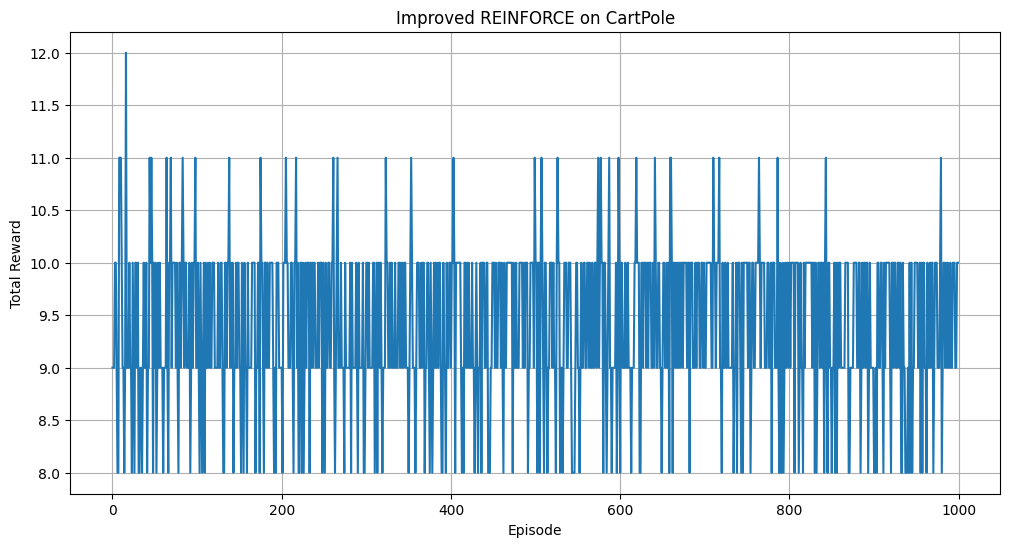

In [12]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("CartPole-v1")

# Initialize network weights
W1 = torch.randn(4, 128, requires_grad=True)
b1 = torch.zeros(128, requires_grad=True)
W2 = torch.randn(128, 2, requires_grad=True)
b2 = torch.zeros(2, requires_grad=True)

# Optimizer with smaller learning rate
optimizer = optim.Adam([W1, b1, W2, b2], lr=1e-3)

# Policy forward pass
def policy_forward(state):
    x = F.relu(state @ W1 + b1)
    logits = x @ W2 + b2
    return F.softmax(logits, dim=-1)

# Discounted return computation with normalization
def compute_returns(rewards, gamma=0.99):
    G = 0
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

# Training loop
num_episodes = 1000
all_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32)

    states, actions, rewards = [], [], []
    total_reward, done = 0, False

    while not done:
        action_probs = policy_forward(state)
        action = torch.multinomial(action_probs, 1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = torch.tensor(next_state, dtype=torch.float32)
        total_reward += reward

    # Compute normalized returns
    returns = compute_returns(rewards)

    # Update policy
    for i in range(len(states)):
        probs = policy_forward(states[i])
        log_prob = torch.log(probs[actions[i]])
        loss = -log_prob * returns[i]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_rewards.append(total_reward)
    if (episode + 1) % 50 == 0:
        print(f"Episode {episode + 1}: Reward = {total_reward}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(all_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Improved REINFORCE on CartPole")
plt.grid(True)
plt.show()
